In [8]:
import torch
from torch import nn
from torch import optim
# Import MNIST dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Import matplotlib for plotting
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Get MNIST dataset
mnist_train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 9.91M/9.91M [00:13<00:00, 753kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 220kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


In [4]:
# Check the size of the dataset
print(f"Training set size: {len(mnist_train)}")

Training set size: 60000


In [5]:
# Show some images from the dataset
def show_images(images, labels):
    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(labels[i].item())
        plt.axis('off')
    plt.show()

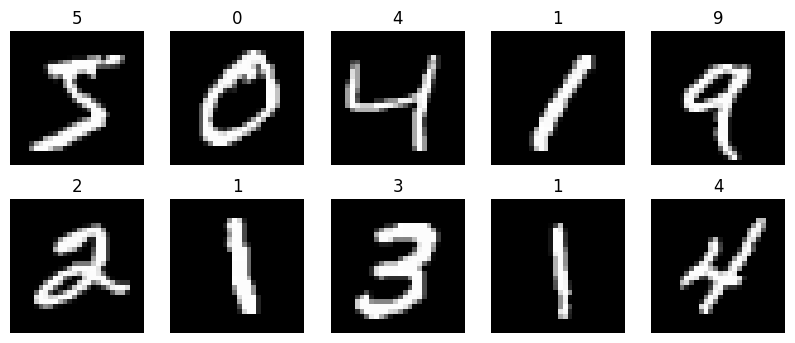

In [6]:
# Show some images
images, labels = next(iter(DataLoader(mnist_train, batch_size=10)))
show_images(images, labels)

In [9]:
# Simple neural network model
class CharacterMnistNetwork(nn.Module):

    def __init__(self):
        super(CharacterMnistNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
model = CharacterMnistNetwork().to(device)

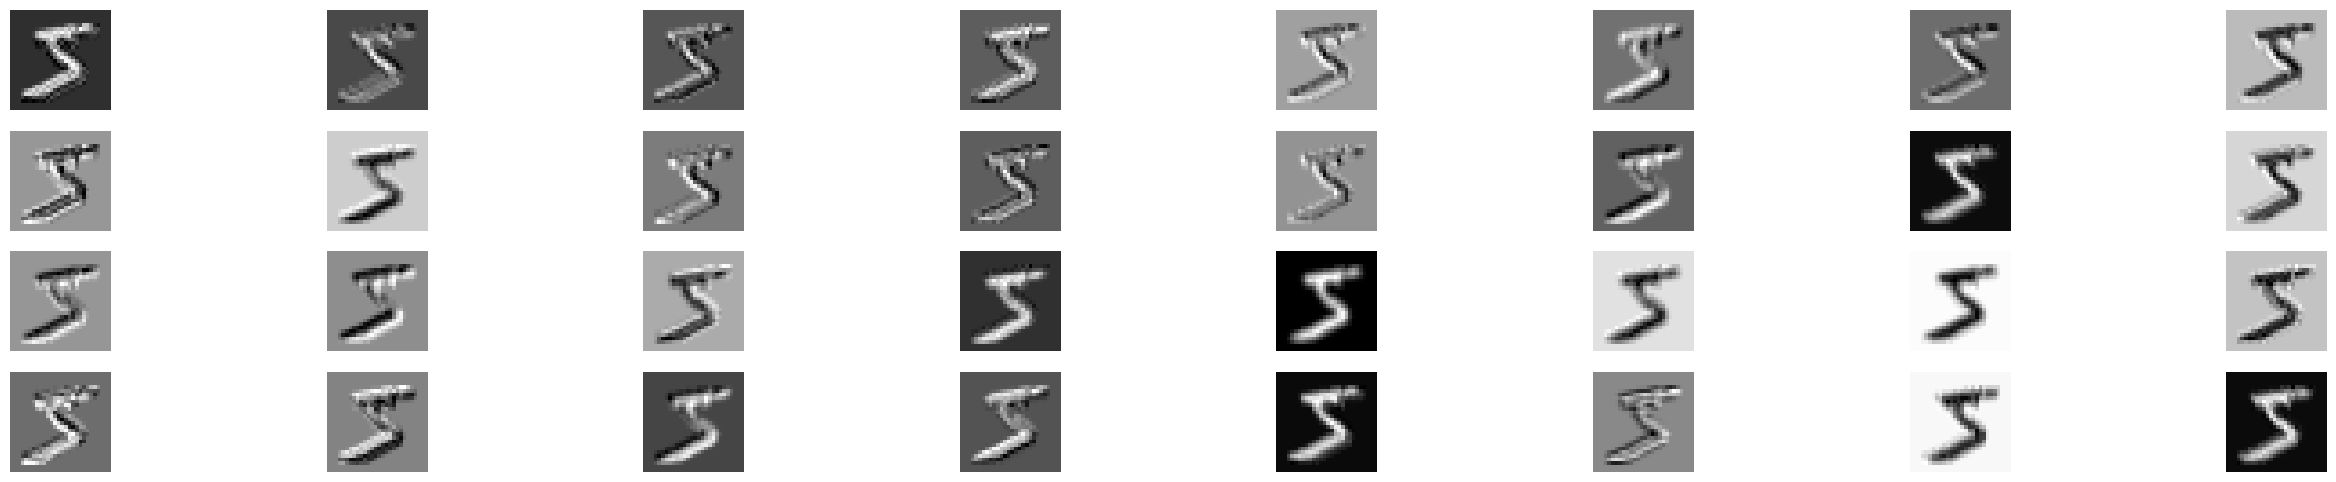

In [13]:
# Let's infer an image from the dataset
image, label = mnist_train[0]
# Show the result of the model after one convolution
image = image.unsqueeze(0).to(device)
# Get the first convolution
conv1 = model.conv1(image)
# Get the first convolution
conv1 = conv1.squeeze().cpu().detach().numpy()
# Show the result of the convolution
plt.figure(figsize=(32, 6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(conv1[i], cmap='gray')
    plt.axis('off')

plt.show()

In [24]:
# Training the model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    train_loss, val_loss, accuracy, precision = [], [], [], []
    # Set the model to training mode
    model.train()
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
        # Append the loss
        train_loss.append(train_running_loss / len(train_loader))
        # Validation loss
        val_running_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        # Append the loss
        val_loss.append(val_running_loss / len(train_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_running_loss / len(train_loader):.4f}, Val Loss: {val_running_loss / len(test_loader):.4f}")
        # Track accuracy for a test set
        # Get the model to evaluation mode
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        _accuracy = 100 * correct / total
        print(f"Accuracy: {_accuracy:.2f}%")
        accuracy.append(_accuracy)

    return train_loss, val_loss, accuracy


In [25]:
# Train the model
model = CharacterMnistNetwork().to(device)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss, val_loss, accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5], Loss: 0.1729, Val Loss: 0.0491
Accuracy: 100.00%
Epoch [2/5], Loss: 0.0506, Val Loss: 0.0412
Accuracy: 100.00%
Epoch [3/5], Loss: 0.0341, Val Loss: 0.0262
Accuracy: 100.00%
Epoch [4/5], Loss: 0.0250, Val Loss: 0.0242
Accuracy: 100.00%
Epoch [5/5], Loss: 0.0196, Val Loss: 0.0291
Accuracy: 100.00%


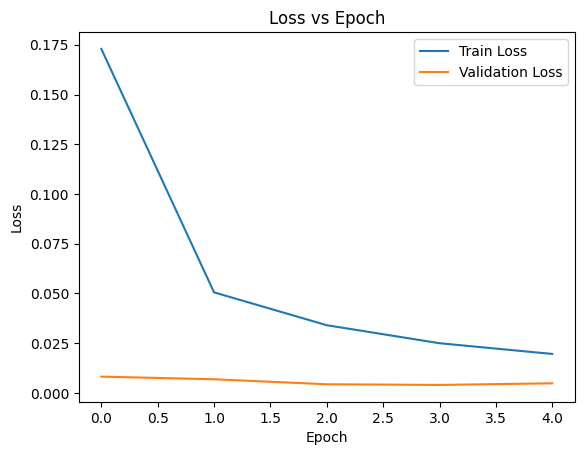

In [26]:
# Plot the loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

In [27]:
# Train the model
model = CharacterMnistNetwork().to(device)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss, val_loss, accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)

Epoch [1/25], Loss: 0.1890, Val Loss: 0.0687
Accuracy: 100.00%
Epoch [2/25], Loss: 0.0526, Val Loss: 0.0357
Accuracy: 100.00%
Epoch [3/25], Loss: 0.0369, Val Loss: 0.0320
Accuracy: 100.00%
Epoch [4/25], Loss: 0.0272, Val Loss: 0.0405
Accuracy: 100.00%
Epoch [5/25], Loss: 0.0212, Val Loss: 0.0301
Accuracy: 100.00%
Epoch [6/25], Loss: 0.0163, Val Loss: 0.0345
Accuracy: 100.00%
Epoch [7/25], Loss: 0.0137, Val Loss: 0.0317
Accuracy: 100.00%
Epoch [8/25], Loss: 0.0120, Val Loss: 0.0338
Accuracy: 100.00%
Epoch [9/25], Loss: 0.0090, Val Loss: 0.0299
Accuracy: 100.00%
Epoch [10/25], Loss: 0.0062, Val Loss: 0.0321
Accuracy: 100.00%
Epoch [11/25], Loss: 0.0078, Val Loss: 0.0354
Accuracy: 100.00%
Epoch [12/25], Loss: 0.0047, Val Loss: 0.0433
Accuracy: 100.00%
Epoch [13/25], Loss: 0.0065, Val Loss: 0.0411
Accuracy: 100.00%
Epoch [14/25], Loss: 0.0047, Val Loss: 0.0372
Accuracy: 100.00%
Epoch [15/25], Loss: 0.0037, Val Loss: 0.0396
Accuracy: 100.00%
Epoch [16/25], Loss: 0.0046, Val Loss: 0.0360
Acc

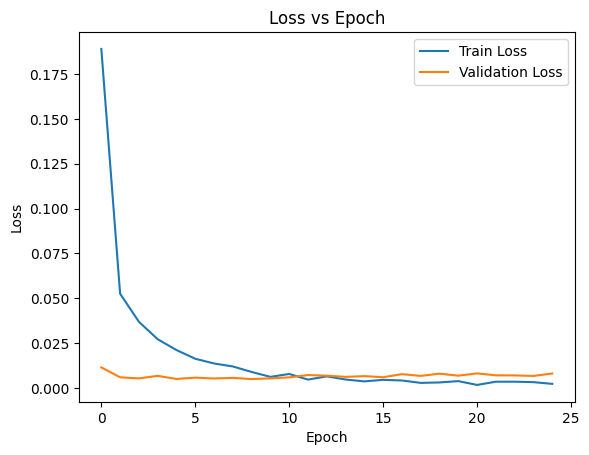

In [28]:
# Plot the loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

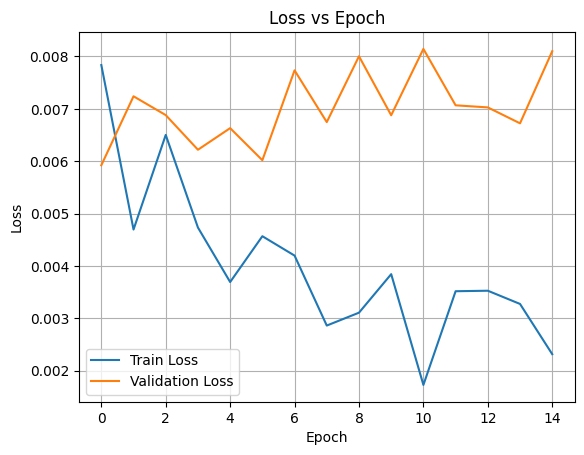

In [29]:
# Plot the loss after the first 10 epochs
plt.plot(train_loss[10:], label='Train Loss')
plt.plot(val_loss[10:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.grid()
plt.show()

In [30]:
# Training the model
def train_model_early_stop(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    train_loss, val_loss, accuracy, precision = [], [], [], []
    # Set the model to training mode
    model.train()
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
        # Append the loss
        train_loss.append(train_running_loss / len(train_loader))
        # Validation loss
        val_running_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        # Append the loss
        val_loss.append(val_running_loss / len(train_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_running_loss / len(train_loader):.4f}, Val Loss: {val_running_loss / len(test_loader):.4f}")
        # Track accuracy for a test set
        # Get the model to evaluation mode
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        _accuracy = 100 * correct / total
        print(f"Accuracy: {_accuracy:.2f}%")
        accuracy.append(_accuracy)
        # Early stopping (train compared to validation loss)
        if epoch > 0 and val_loss[-1] > val_loss[-2] and val_loss[-1] > train_loss[-1]:
            print("Early stopping")
            break

    return train_loss, val_loss, accuracy

In [31]:
# Train the model
model = CharacterMnistNetwork().to(device)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss, val_loss, accuracy = train_model_early_stop(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)

Epoch [1/25], Loss: 0.1784, Val Loss: 0.0469
Accuracy: 100.00%
Epoch [2/25], Loss: 0.0497, Val Loss: 0.0355
Accuracy: 100.00%
Epoch [3/25], Loss: 0.0341, Val Loss: 0.0339
Accuracy: 100.00%
Epoch [4/25], Loss: 0.0259, Val Loss: 0.0301
Accuracy: 100.00%
Epoch [5/25], Loss: 0.0196, Val Loss: 0.0310
Accuracy: 100.00%
Epoch [6/25], Loss: 0.0158, Val Loss: 0.0295
Accuracy: 100.00%
Epoch [7/25], Loss: 0.0119, Val Loss: 0.0283
Accuracy: 100.00%
Epoch [8/25], Loss: 0.0103, Val Loss: 0.0329
Accuracy: 100.00%
Epoch [9/25], Loss: 0.0088, Val Loss: 0.0478
Accuracy: 100.00%
Epoch [10/25], Loss: 0.0076, Val Loss: 0.0379
Accuracy: 100.00%
Epoch [11/25], Loss: 0.0061, Val Loss: 0.0393
Accuracy: 100.00%
Early stopping


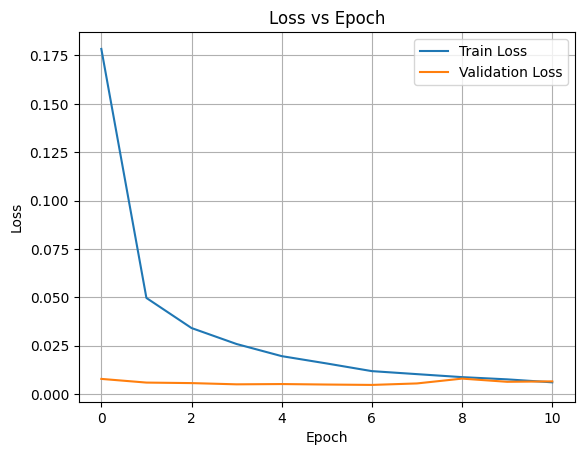

In [33]:
# Plot the loss after the first 10 epochs
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.grid()
plt.show()